# 423 Big Data Final Project

## Notebook Set-up [**Run this when opening the notebook**] ✅

In [ ]:
## Set up PySpark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from datetime import datetime, date, timedelta
from dateutil import relativedelta
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import DataFrame
import random
import pandas as pd

In [ ]:
spark = SparkSession.builder \
    .appName("423project") \
    .getOrCreate()

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Joining and Preping Data [**Don't need to run this section now**] ❌

In [ ]:
path_cities = "/content/drive/Shareddrives/423 Big Data Think Tank/Final Project/Data/uscities.csv"
path_accidents = "/content/drive/Shareddrives/423 Big Data Think Tank/Final Project/Data/US_Accidents.csv"

In [ ]:
cities = spark.read.csv(path_cities, inferSchema=True, header=True)
accidents = spark.read.csv(path_accidents, inferSchema=True, header=True)

In [ ]:
cities.show()

In [ ]:
accidents.show()

**Prepping**

accidents df:
1. standardize zip code format. keep on first 5 number
  * for example, xxxxx-yyyy to xxxxx
2. formatted ID column to keep just the numbers


cities df:
1. Renamed a few columns to capitalize the first letter



In [ ]:
# Convert the column names to lower case for matching
cities = cities.withColumnRenamed("city", "City")
cities = cities.withColumnRenamed("population", "Population")

In [ ]:
# Standardize Zipcode format to xxxxx
accidents = accidents.withColumn('Zipcode', regexp_extract(accidents.Zipcode, r'^(\d{5})', 1))

# Format ID column values to keep just the numbers
accidents = accidents.withColumn('ID', regexp_replace(accidents.ID, 'A-', ''))

In [ ]:
accidents.show()

In [ ]:
accidents.count()

In [ ]:
cities.count()

**Joining**

In [ ]:
accidents.createOrReplaceTempView("accidents")
cities.createOrReplaceTempView("cities")

In [ ]:
# Joinning on city name, state name, the accidents.zipcode is in cities.zips
df_joined = spark.sql("""
    SELECT accidents.*, cities.Population
    FROM accidents
    LEFT JOIN cities ON accidents.City=cities.City 
                        AND accidents.State=cities.state_id 
                        AND array_contains(split(cities.zips, ' '), accidents.Zipcode)
""")

In [ ]:
df_joined.show()

In [ ]:
df_joined.count()

**Cleaning**

df_joined df:
1. Extract year, month, weekday, and duration fields from the "Start_Time" and "End_Time" columns
2. Created a categorized TOD field
  * Midnight: 12am - 4am
  * Early Morning: 4am - 8am
  * Late Morning: 8am - 12pm
  * Early Afternoon: 12pm - 4pm
  * Late Afternoon: 4pm - 8pm
  * Evening: 8pm - 12am


In [ ]:
# Convert time-related fields to datetime type
df_joined = df_joined.withColumn('Start_Time', to_timestamp(col('Start_Time')))
df_joined = df_joined.withColumn('End_Time', to_timestamp(col('End_Time')))
df_joined = df_joined.withColumn('Weather_Timestamp', to_timestamp(col('Weather_Timestamp')))

In [ ]:
# Create year, month, and weekday fields
df_joined = df_joined.withColumn('Start_Year', year(col('Start_Time')))
df_joined = df_joined.withColumn('Start_Month', month(col('Start_Time')))
df_joined = df_joined.withColumn('Start_Weekday', dayofweek(col('Start_Time')))

In [ ]:
# Create a categorized TOD field
df_joined = df_joined.withColumn('Start_TOD', hour(col('Start_Time')))
bins = [0, 4, 8, 12, 16, 20, 24]
labels = ['Midnight', 'Early Morning', 'Late Morning', 'Early Afternoon', 'Late Afternoon', 'Evening']
df_joined = df_joined.withColumn('Start_TOD_Category', 
                                 when((col('Start_TOD') >= bins[0]) & (col('Start_TOD') < bins[1]), labels[0])
                                 .when((col('Start_TOD') >= bins[1]) & (col('Start_TOD') < bins[2]), labels[1])
                                 .when((col('Start_TOD') >= bins[2]) & (col('Start_TOD') < bins[3]), labels[2])
                                 .when((col('Start_TOD') >= bins[3]) & (col('Start_TOD') < bins[4]), labels[3])
                                 .when((col('Start_TOD') >= bins[4]) & (col('Start_TOD') < bins[5]), labels[4])
                                 .otherwise(labels[5]))
df_joined = df_joined.drop('Start_TOD')

In [ ]:
# Create a Duration column to calculate time taken to resume traffic after accident
start_unix = unix_timestamp(col("Start_Time"))
end_unix = unix_timestamp(col("End_Time"))
df_joined = df_joined.withColumn("Duration", round((end_unix - start_unix) / 3600, 2))

+------+--------+-------------------+-------------------+------------------+-------------------+---------+-------------------+------------------+--------------------+-------+-------------------+----+-------------+------------+-----+-------+-------+-----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----------+----------+-----------+-------------+------------------+--------+
|    ID|Severity|         Start_Time|           End_Time|         Start_Lat|          Start_Lng|  End_Lat|            End_Lng|      Distance(mi)|         Description| Number|             Street|Side|         City|      County|State|Zipcode|Country|   Timezone|Airport_Code|  Weather_Timestamp|Tempe

In [ ]:
df_joined.printSchema()

In [ ]:
df_joined.show(30)

In [ ]:
# Save the dataframe as a CSV file
# Will use this file to start the next process
data_folder = '/content/drive/Shareddrives/423 Big Data Think Tank/Final Project/Data/US_Traffic_v02.csv'
df_joined.write.csv(data_folder, header=True)

## Load Cleaned Data [**Run From here**] ✅

In [ ]:
cleaned_data = '/content/drive/Shareddrives/423 Big Data Think Tank/Final Project/Data/US_Traffic_v02.csv'

In [ ]:
# Load cleaned data into the notebook
data = spark.read.csv(cleaned_data, inferSchema=True, header=True)

In [ ]:
# Sample 10% of the data, without replacement
data = data.sample(False, 0.1)

In [ ]:
data.show()

+------+--------+-------------------+-------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+-------+-----------------+----+------------------+----------------+-----+-------+-------+-----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----------+----------+-----------+-------------+------------------+--------+
|    ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|           End_Lat|            End_Lng|        Distance(mi)|         Description| Number|           Street|Side|              City|          County|State|Zipcode|Country|   Timezone|Airp

In [ ]:
data.count()

284420

In [ ]:
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressur

## Descriptive Analytics

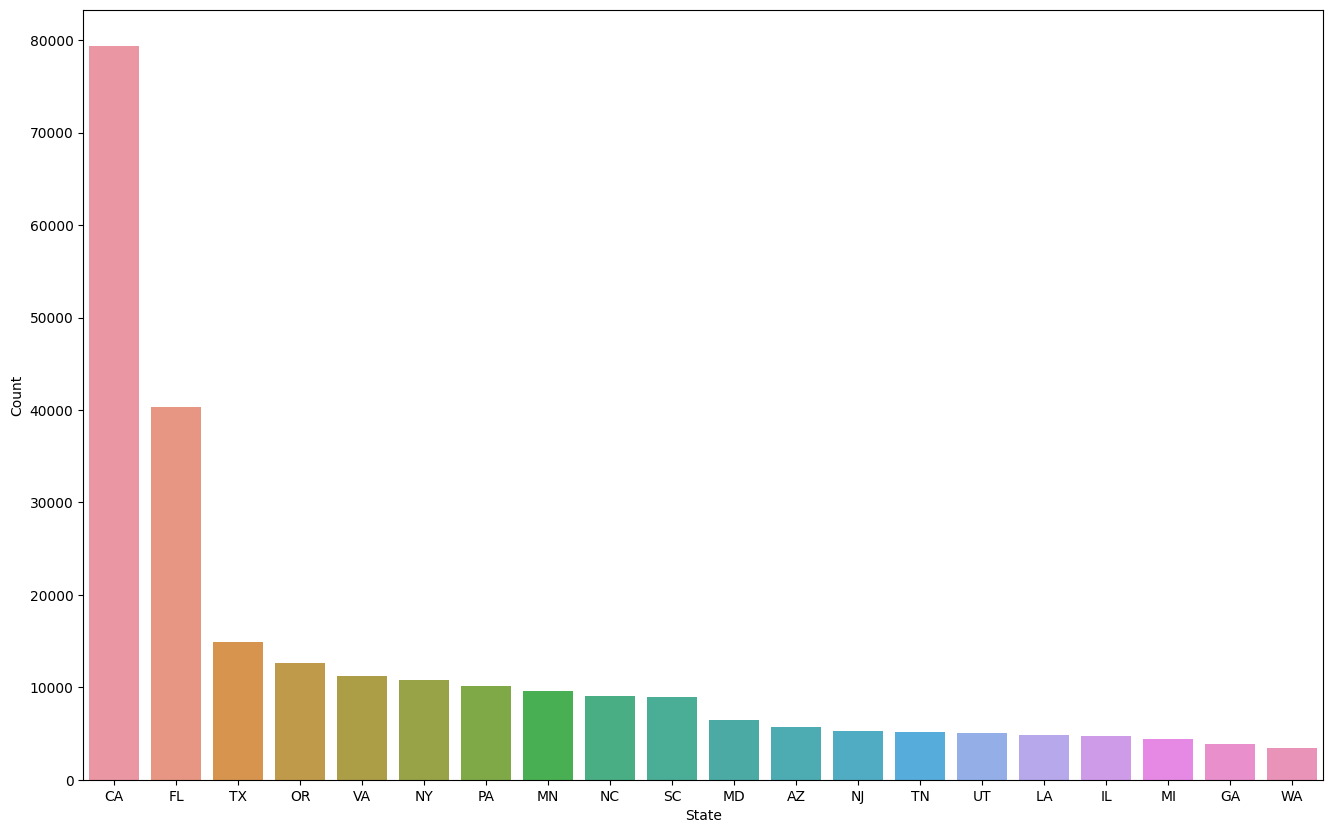

In [ ]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate count of 'ID' for each unique state
count_by_state = data.groupBy("State").agg(count("ID").alias("Count"))
count_by_state = count_by_state.orderBy(desc("Count")).limit(20)

# Collect data to driver node
count_by_state_pandas = count_by_state.toPandas()

# Plot using seaborn
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(x="State", y="Count", data=count_by_state_pandas)
plt.show()

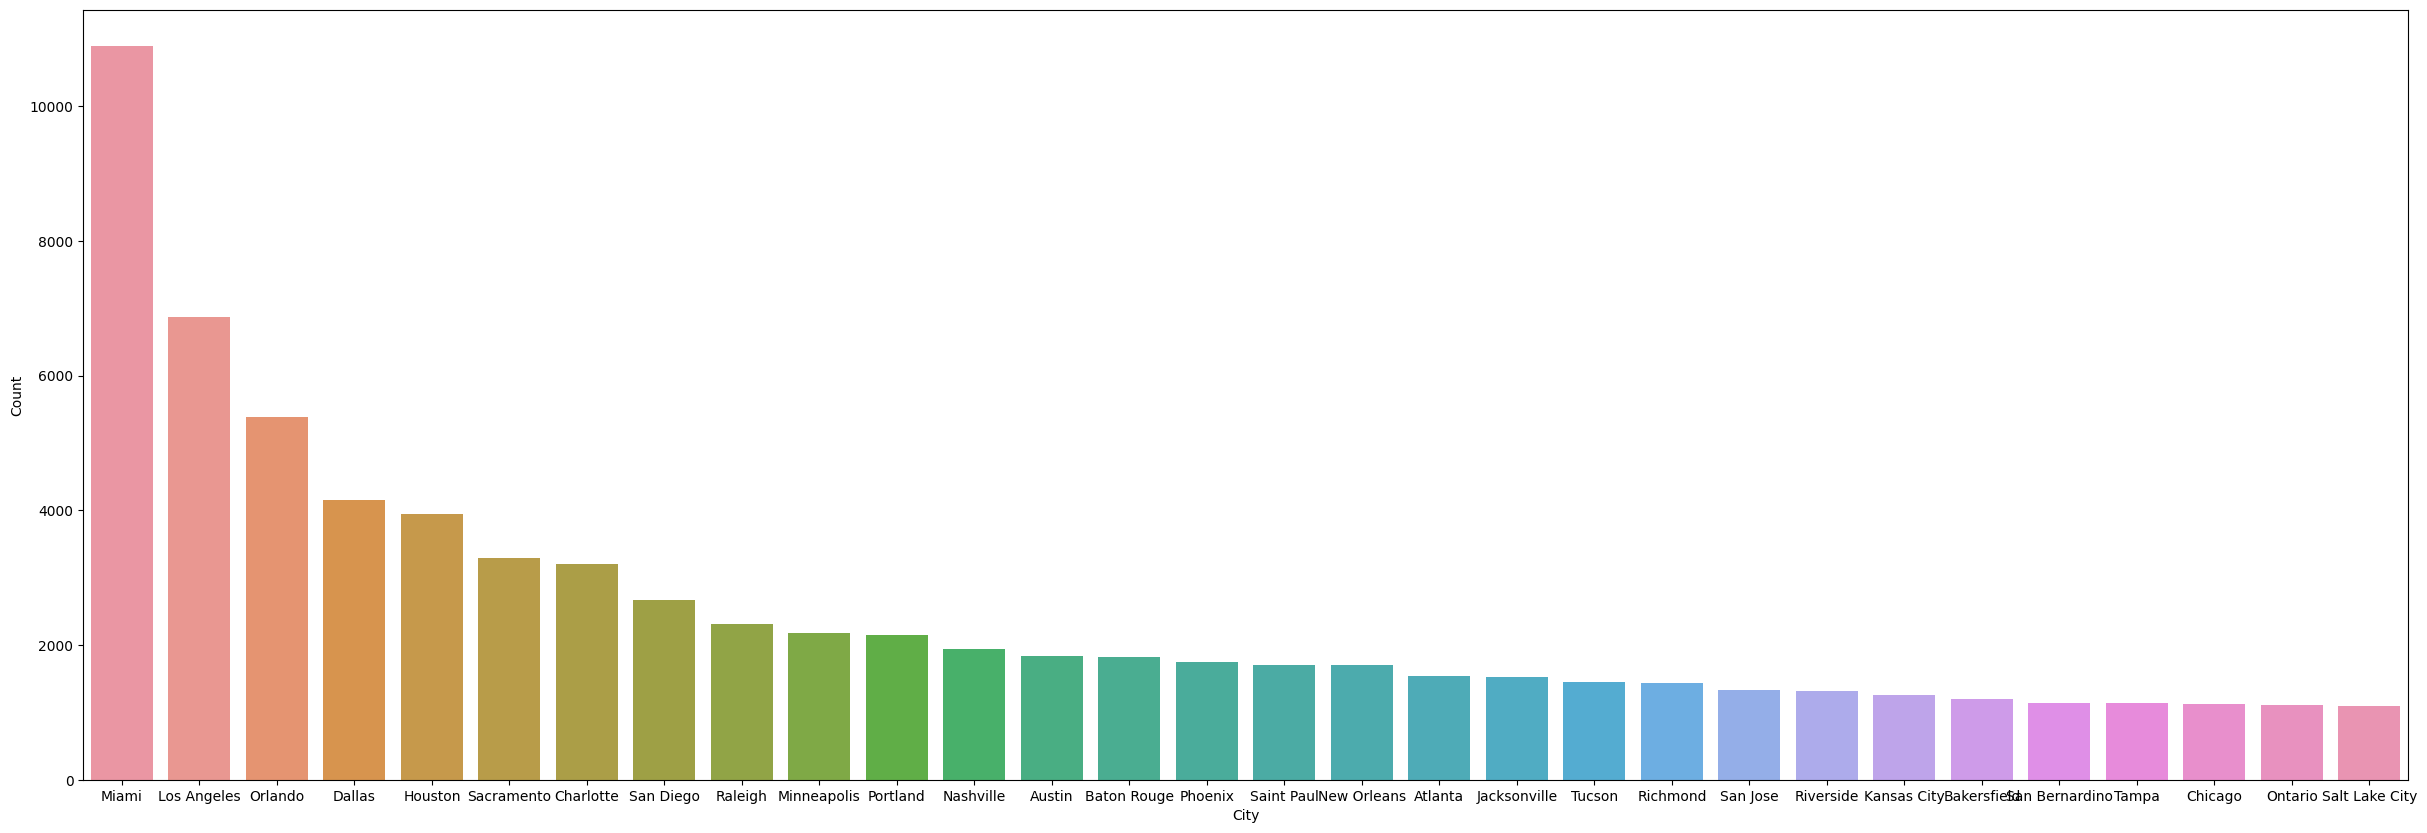

In [ ]:
# Calculate count of 'ID' for each unique state
count_by_city = data.groupBy("City").agg(count("ID").alias("Count"))
count_by_city = count_by_city.orderBy(desc("Count")).limit(30)

# Collect data to driver node
count_by_city_pandas = count_by_city.toPandas()

# Plot using seaborn
fig, ax = plt.subplots(figsize=(30,10))
sns.barplot(x="City", y="Count", data=count_by_city_pandas)
plt.show()

In [ ]:
count_by_city.show(30)


+--------------+-----+
|          City|Count|
+--------------+-----+
|         Miami|10887|
|   Los Angeles| 6865|
|       Orlando| 5385|
|        Dallas| 4153|
|       Houston| 3938|
|    Sacramento| 3285|
|     Charlotte| 3197|
|     San Diego| 2668|
|       Raleigh| 2315|
|   Minneapolis| 2181|
|      Portland| 2150|
|     Nashville| 1941|
|        Austin| 1834|
|   Baton Rouge| 1815|
|       Phoenix| 1742|
|    Saint Paul| 1710|
|   New Orleans| 1699|
|       Atlanta| 1541|
|  Jacksonville| 1522|
|        Tucson| 1444|
|      Richmond| 1438|
|      San Jose| 1337|
|     Riverside| 1314|
|   Kansas City| 1252|
|   Bakersfield| 1204|
|San Bernardino| 1137|
|         Tampa| 1135|
|       Chicago| 1131|
|       Ontario| 1112|
|Salt Lake City| 1095|
+--------------+-----+



this view does not actually show us the real tendency of how many accidents there are per capita, or per the amount of drivers on the road.

In [ ]:
cleaned_data2 = '/content/drive/Shareddrives/423 Big Data Think Tank/Final Project/Data/uscities1.csv'

In [ ]:
pop = spark.read.csv(cleaned_data2, inferSchema=True, header=True)
pop = pop.withColumnRenamed("city", "City")

df = count_by_city.join(pop, on=['City'], how='inner').select(count_by_city["City"], count_by_city["Count"], pop["Population"])
df.show()


+--------------+-----+----------+
|          City|Count|Population|
+--------------+-----+----------+
|   Los Angeles| 6865|  12121244|
|       Chicago| 1131|   8595181|
|         Miami|10887|   5711945|
|        Dallas| 4153|   5668165|
|       Houston| 3938|   5650910|
|       Atlanta| 1541|   5046555|
|       Phoenix| 1742|   4047095|
|     San Diego| 2668|   3084174|
|   Minneapolis| 2181|   2856952|
|         Tampa| 1135|   2683956|
|      Portland| 2150|   2036875|
|     Riverside| 1314|   2022285|
|       Orlando| 5385|   1927699|
|    Sacramento| 3285|   1924167|
|      San Jose| 1337|   1729879|
|        Austin| 1834|   1659251|
|   Kansas City| 1252|   1644497|
|     Charlotte| 3197|   1516107|
|  Jacksonville| 1522|   1220191|
|Salt Lake City| 1095|   1135344|
+--------------+-----+----------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import col
df = df.withColumn("PerCapita", col("Count") / col("Population"))
df = df.orderBy(desc("PerCapita"))



In [ ]:
df_pandas = df.toPandas()


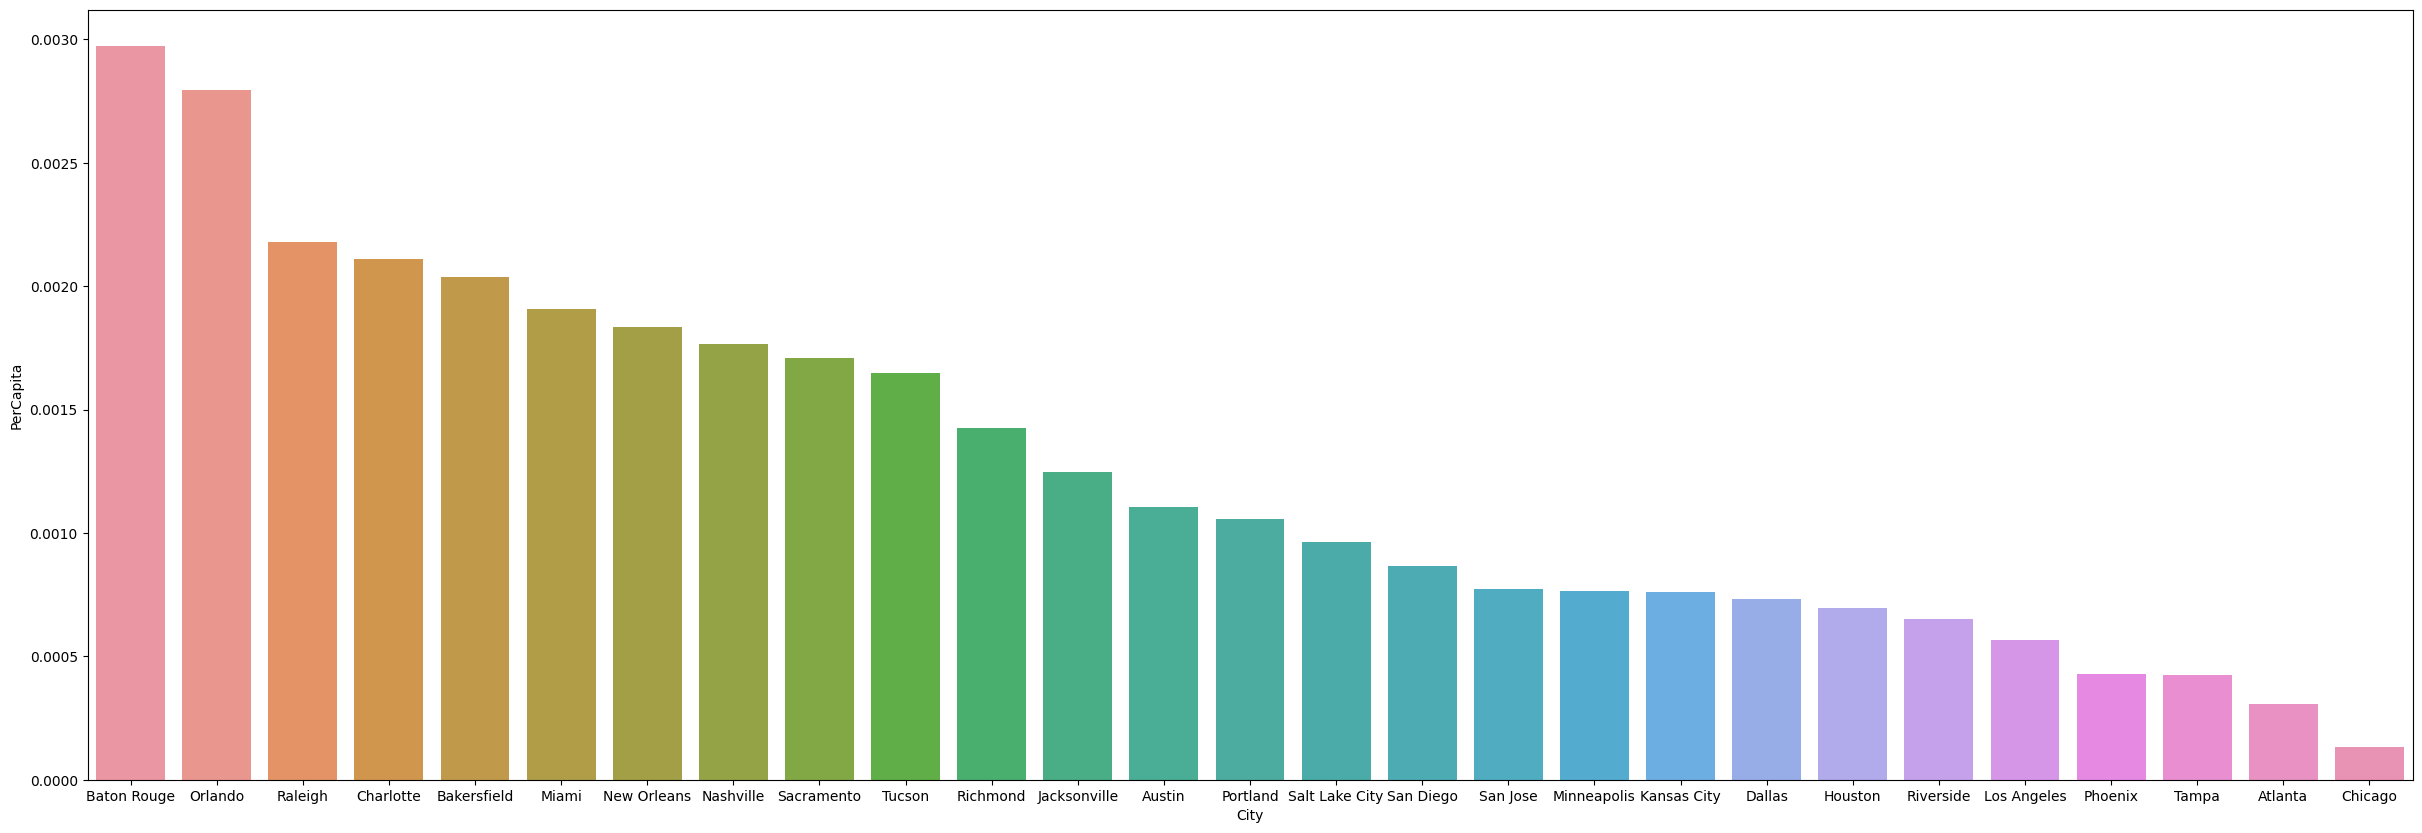

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))
sns.barplot(x="City", y="PerCapita", data=df_pandas)
plt.show()


More population doesn't necessary mean more accidents. 

Model?!?

I had to get rid of all nulls or mean the nulls in order to run ML model

In [ ]:
data.show()

+------+--------+-------------------+-------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+-------+-----------------+----+------------------+----------------+-----+-------+-------+-----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----------+----------+-----------+-------------+------------------+--------+
|    ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|           End_Lat|            End_Lng|        Distance(mi)|         Description| Number|           Street|Side|              City|          County|State|Zipcode|Country|   Timezone|Airp

In [ ]:
df=data

In [ ]:
from pyspark.sql.functions import mean

mean_value = data.select(mean(df['Temperature(F)'])).collect()
mean_temperature = mean_value[0][0]
df = data.na.fill(mean_temperature, subset=['Temperature(F)'])


In [ ]:
from pyspark.sql.functions import mean

mean_value = data.select(mean(df['Precipitation(in)'])).collect()
mean_temperature = mean_value[0][0]
df = df.na.fill(mean_temperature, subset=['Precipitation(in)'])



mean_value = df.select(mean(df['Wind_Chill(F)'])).collect()
mean_temperature = mean_value[0][0]
df = df.na.fill(mean_temperature, subset=['Wind_Chill(F)'])


mean_value = df.select(mean(df['Wind_Speed(mph)'])).collect()
mean_temperature = mean_value[0][0]
df = df.na.fill(mean_temperature, subset=['Wind_Speed(mph)'])



In [ ]:
df = df.na.drop()
df.show()

+------+--------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+-------+--------------------+----+--------------+-----------+-----+-------+-------+-----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----------+----------+-----------+-------------+------------------+--------+
|    ID|Severity|         Start_Time|           End_Time|         Start_Lat|          Start_Lng|           End_Lat|            End_Lng|        Distance(mi)|         Description| Number|              Street|Side|          City|     County|State|Zipcode|Country|   Timezone|Airport_Code| 

## Predictive Analytics

In [ ]:
#remove unnesecary variables for feature importance
df = df.drop('Start_Lat', 'Start_Lng', 'Number','End_Lat','End_Lng')


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import col

# Selecting only float type columns
float_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, FloatType) or isinstance(f.dataType, DoubleType)]

# Exclude 'Severity' column
x_cols = [col for col in float_cols if col not in ['Severity']]

# Assemble features
assembler = VectorAssembler(inputCols=x_cols, outputCol="features")
df = assembler.transform(df)

# Convert 'Severity' to float type
df = df.withColumn("Severity", df["Severity"].cast("float"))

# Split dataset for training
(train_df, test_df) = df.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestRegressor(labelCol="Severity", featuresCol="features", numTrees=25, maxDepth=30)
model = rf.fit(train_df)

# Get feature importance
importance = model.featureImportances

# Convert feature importances to pandas for easier handling
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({
    "Feature": x_cols,
    "Importance": importance.toArray()
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values("Importance", ascending=False)



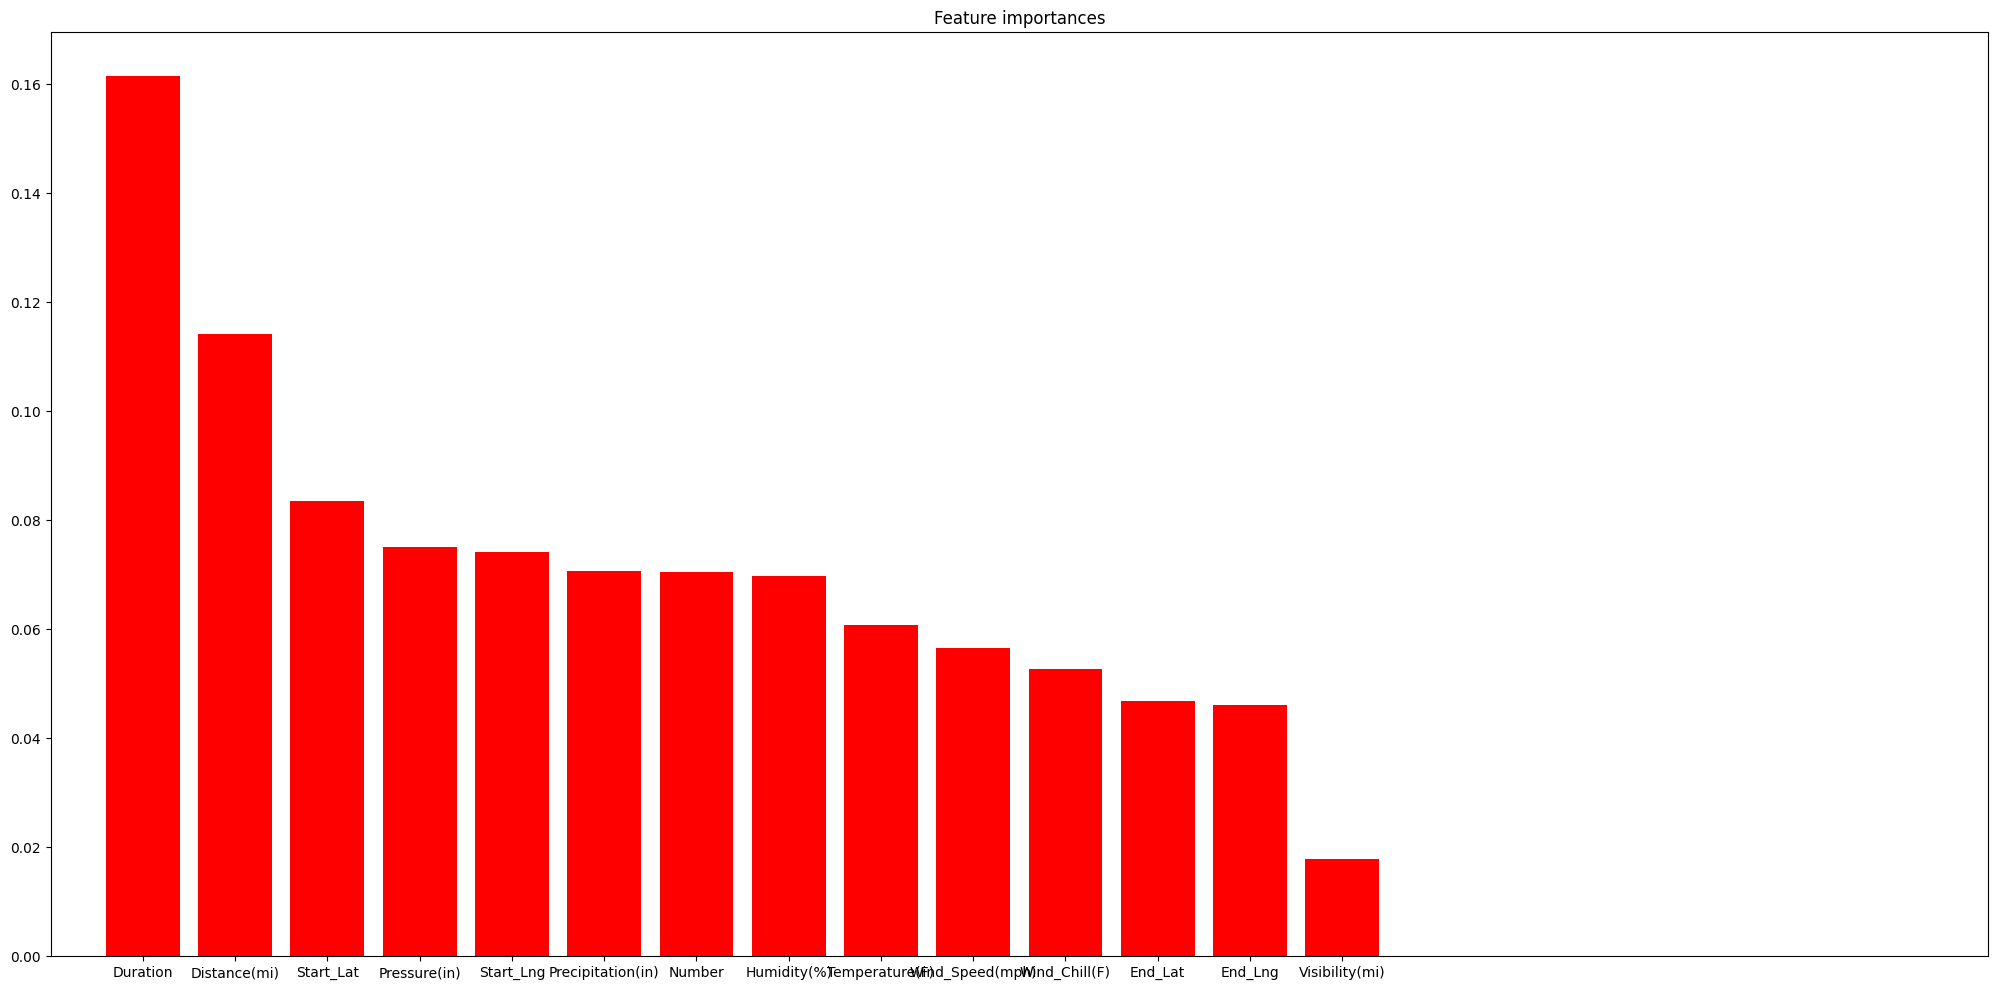

In [ ]:
# Plot the top 20 feature importances
plt.figure(figsize=(25, 12))
plt.title("Feature importances")
plt.bar(importance_df["Feature"][:20], importance_df["Importance"][:20], color="r", align="center")
plt.xlim([-1, 20])
plt.show()

Now do feature importance for Boolean variables:

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import col

# Selecting only boolean type columns
boolean_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, BooleanType)]

# Exclude 'Severity' column
x_cols = [col for col in boolean_cols if col not in ['Severity']]

# Assemble features
assembler = VectorAssembler(inputCols=x_cols, outputCol="features2")
df = assembler.transform(df)

# Convert 'Severity' to float type
df = df.withColumn("Severity", df["Severity"].cast("float"))

# Split dataset for training
(train_df, test_df) = df.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestRegressor(labelCol="Severity", featuresCol="features2", numTrees=25, maxDepth=30)
model = rf.fit(train_df)

# Get feature importance
importance = model.featureImportances

# Convert feature importances to pandas for easier handling
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({
    "features2": x_cols,
    "Importance": importance.toArray()
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values("Importance", ascending=False)



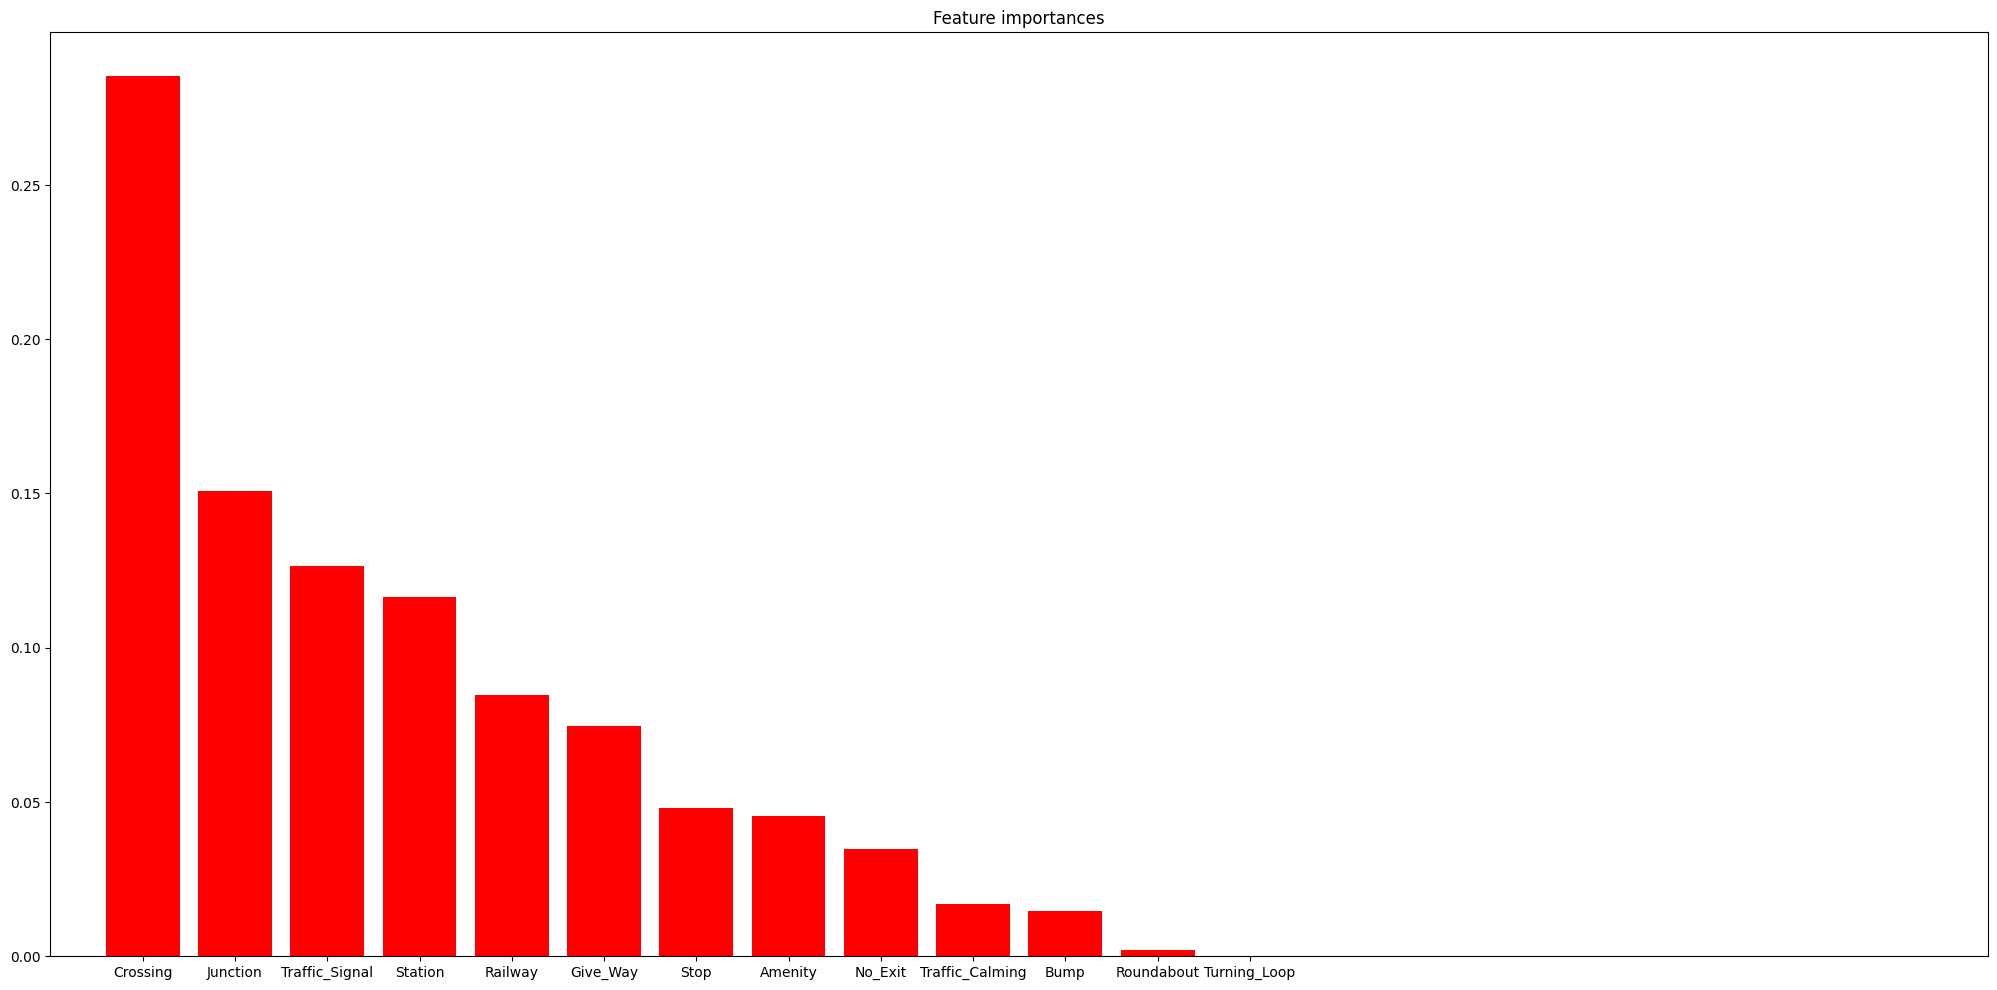

In [ ]:
plt.figure(figsize=(25, 12))
plt.title("Feature importances")
plt.bar(importance_df["features2"][:20], importance_df["Importance"][:20], color="r", align="center")
plt.xlim([-1, 20])
plt.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import col

# Selecting only boolean type columns
boolean_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, BooleanType)]

# Exclude 'Severity' column
x_cols = [col for col in boolean_cols if col not in ['Duration']]

# Assemble features
assembler = VectorAssembler(inputCols=x_cols, outputCol="features3")
df = assembler.transform(df)

# Convert 'Severity' to float type
df = df.withColumn("Duration", df["Duration"].cast("float"))

# Split dataset for training
(train_df, test_df) = df.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestRegressor(labelCol="Duration", featuresCol="features3", numTrees=25, maxDepth=30)
model = rf.fit(train_df)

# Get feature importance
importance = model.featureImportances

# Convert feature importances to pandas for easier handling
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({
    "features3": x_cols,
    "Importance": importance.toArray()
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values("Importance", ascending=False)



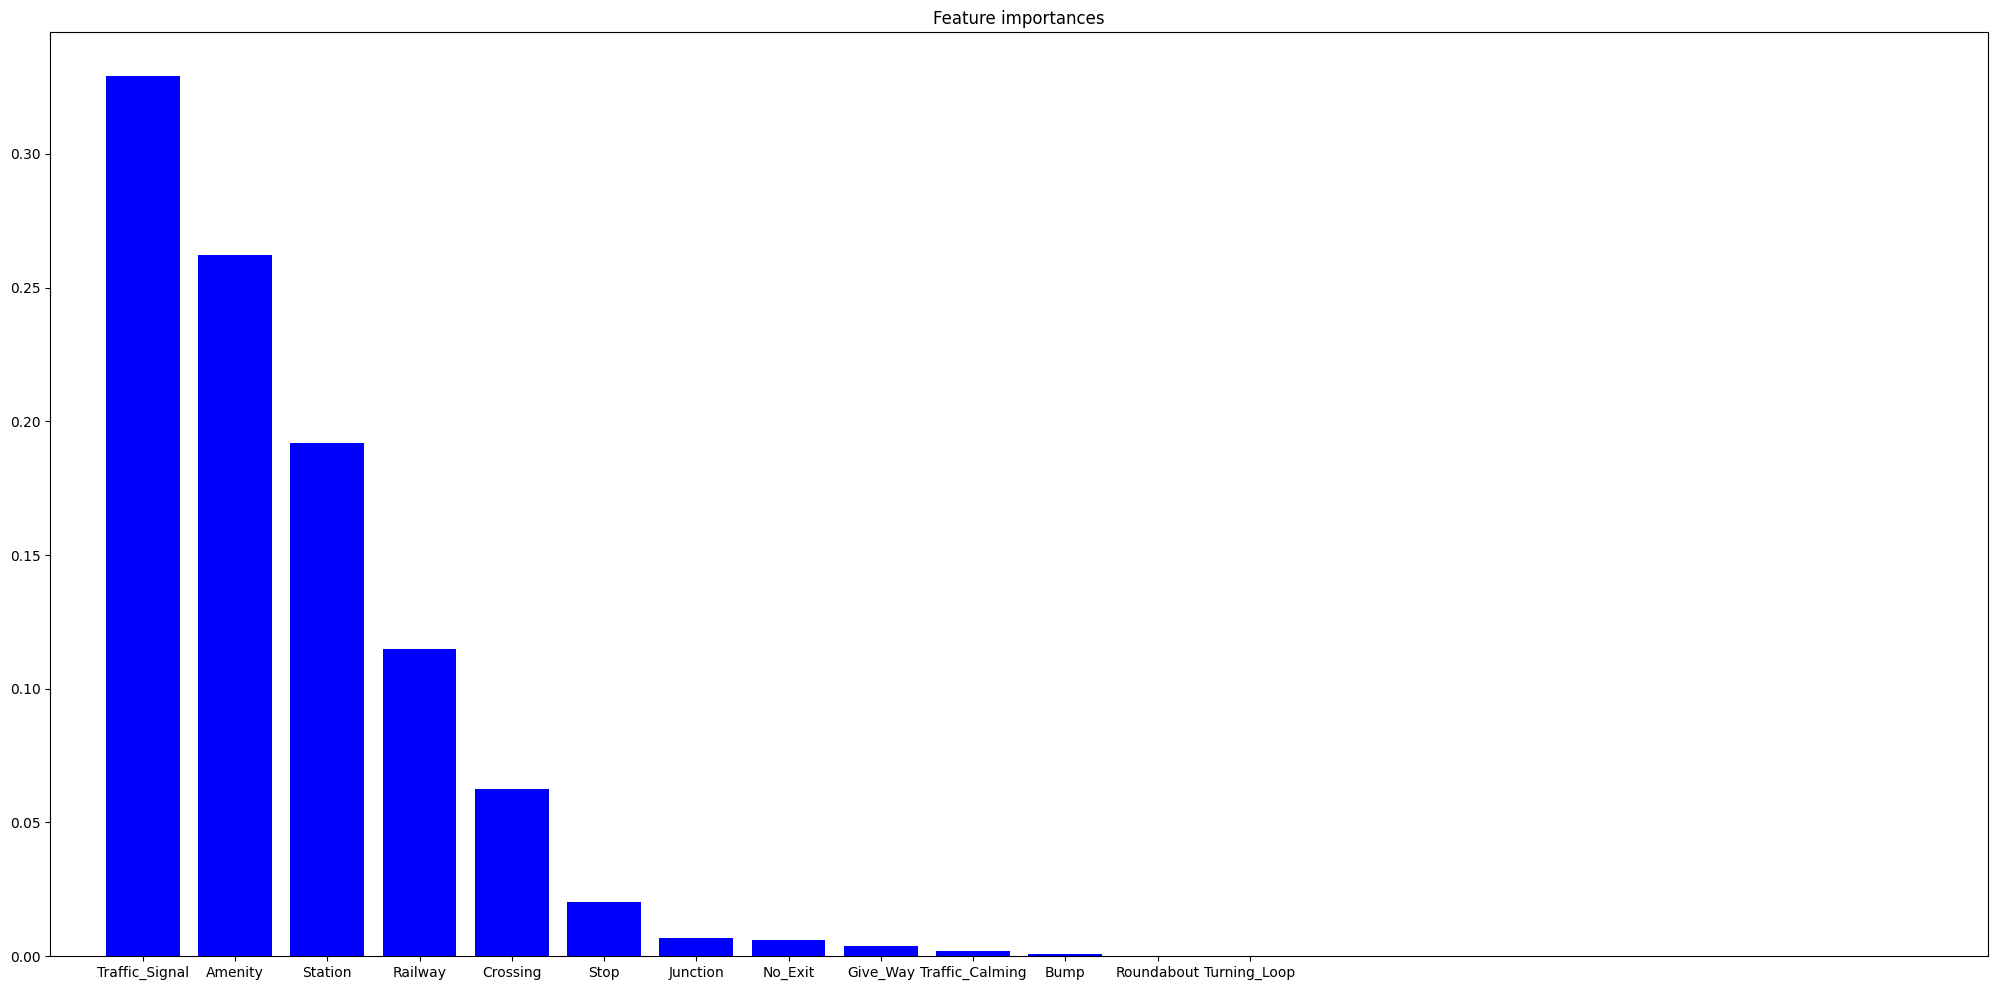

In [ ]:
# Plot the top 20 feature importances
plt.figure(figsize=(25, 12))
plt.title("Feature importances")
plt.bar(importance_df["features3"][:20], importance_df["Importance"][:20], color="b", align="center")
plt.xlim([-1, 20])
plt.show()

In [ ]:
df, test_data = df.randomSplit([0.5, 0.5])

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import col

# Selecting only float type columns
float_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, FloatType) or isinstance(f.dataType, DoubleType)]

# Exclude 'Severity' column
x_cols = [col for col in float_cols if col not in ['Duration']]

# Assemble features
assembler = VectorAssembler(inputCols=x_cols, outputCol="features4")
df = assembler.transform(df)

# Convert 'Severity' to float type
df = df.withColumn("Duration", df["Duration"].cast("float"))

# Split dataset for training
(train_df, test_df) = df.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestRegressor(labelCol="Duration", featuresCol="features4", numTrees=25, maxDepth=30)

model = rf.fit(train_df)

# Get feature importance
importance = model.featureImportances

# Convert feature importances to pandas for easier handling
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({
    "features4": x_cols,
    "Importance": importance.toArray()
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values("Importance", ascending=False)



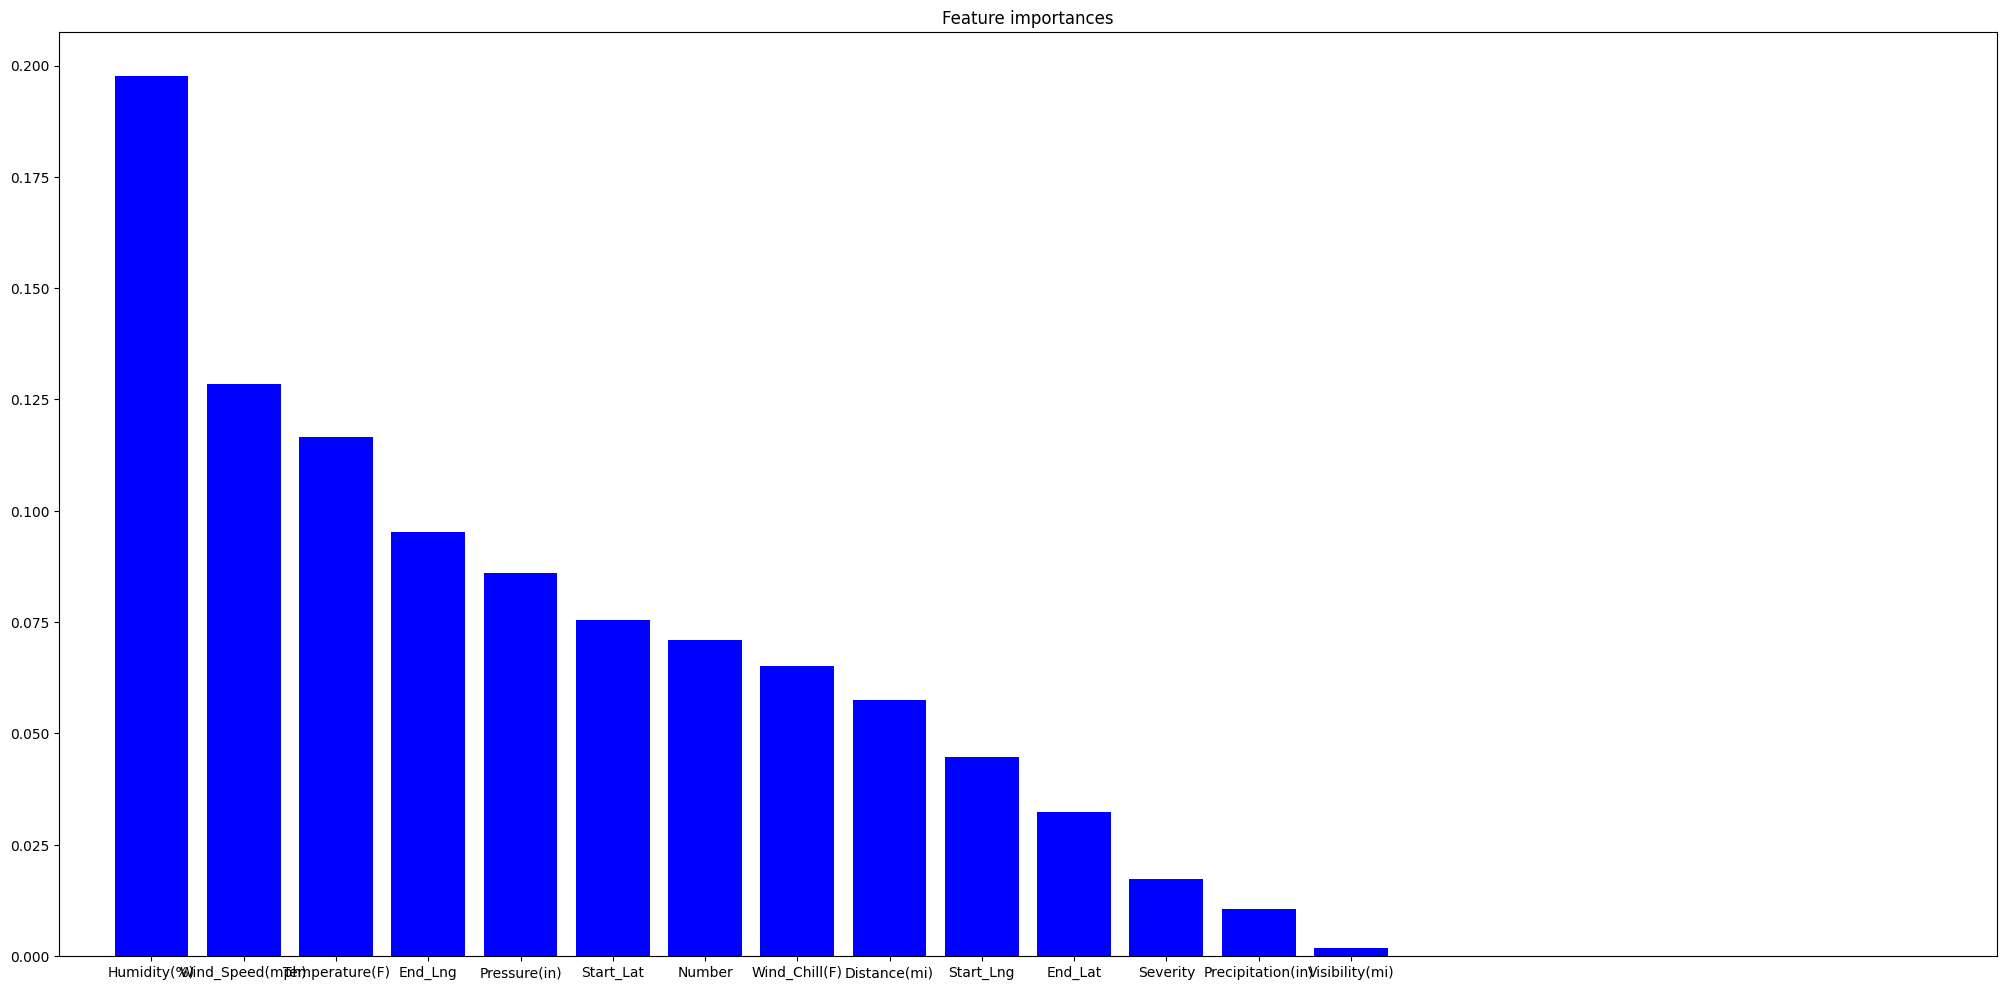

In [ ]:
# Plot the top 20 feature importances
plt.figure(figsize=(25, 12))
plt.title("Feature importances")
plt.bar(importance_df["features4"][:20], importance_df["Importance"][:20], color="b", align="center")
plt.xlim([-1, 20])
plt.show()

## A/B Test with Matching

#### Set-up

In [ ]:
# Load libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, udf, stddev
from pyspark.sql.types import FloatType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Read data
path = "/content/drive/Shareddrives/423 Big Data Think Tank/Final Project/Data/US_Traffic_v02.csv"
data = spark.read.format('csv').option('header', 'true').load(path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Select relevant features
cols_to_remove = ["Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Description", 
                  "Number", "Street", "Country", "Timezone", "Airport_Code", "Zipcode", 
                  "Weather_Timestamp", "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", 
                  "Astronomical_Twilight", "Weather_Condition", "Wind_Direction"]

df = data.select([col for col in data.columns if col not in cols_to_remove])

df = df.na.drop()

# Cast numeric columns to appropriate types
double_columns = ["Distance(mi)", "Temperature(F)", "Wind_Chill(F)", 
                   "Humidity(%)", "Pressure(in)", "Visibility(mi)", 
                   "Wind_Speed(mph)", "Precipitation(in)", "Duration"]

integer_columns = ["Population", "Start_Year", "Start_Month"]

for column in double_columns:
    df = df.withColumn(column, col(column).cast("double"))

for column in integer_columns:
    df = df.withColumn(column, col(column).cast("integer"))

# Remove one outlier row wither Side is "N"
df = df.where(df.Side != 'N')
# Remove outliers where duration is larger than 7 days
df = df.where(df.Duration <= 168)

# Encode binary categorical columns
binary_columns = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

for column in binary_columns:
    df = df.withColumn(column, when(col(column) == "true", 1).otherwise(0))

df = df.withColumn("Side", when(col("Side") == "L", 1).otherwise(0))

# Convert values in Start_TOD_Category column [Necessary for SMOTE]
df = df.withColumn("Start_TOD_Category",
                    when(df["Start_TOD_Category"] == "Midnight", "1")
                   .when(df["Start_TOD_Category"] == "Early Morning", "2")
                   .when(df["Start_TOD_Category"] == "Late Morning", "3")
                   .when(df["Start_TOD_Category"] == "Early Afternoon", "4")
                   .when(df["Start_TOD_Category"] == "Late Afternoon", "5")
                   .when(df["Start_TOD_Category"] == "Evening", "6"))

# First convert the categories from 'string' to 'index'
indexer = StringIndexer(inputCol="Start_TOD_Category", outputCol="Start_TOD_Category_index")
df = indexer.fit(df).transform(df)

indexer = StringIndexer(inputCol="Start_Weekday", outputCol="Start_Weekday_index")
df = indexer.fit(df).transform(df)

# Then one-hot encode these indices
encoder = OneHotEncoder(inputCols=["Start_TOD_Category_index", "Start_Weekday_index"],
                        outputCols=["Start_TOD_Category_vec", "Start_Weekday_vec"])
model = encoder.fit(df)
df = model.transform(df)

#### EDA

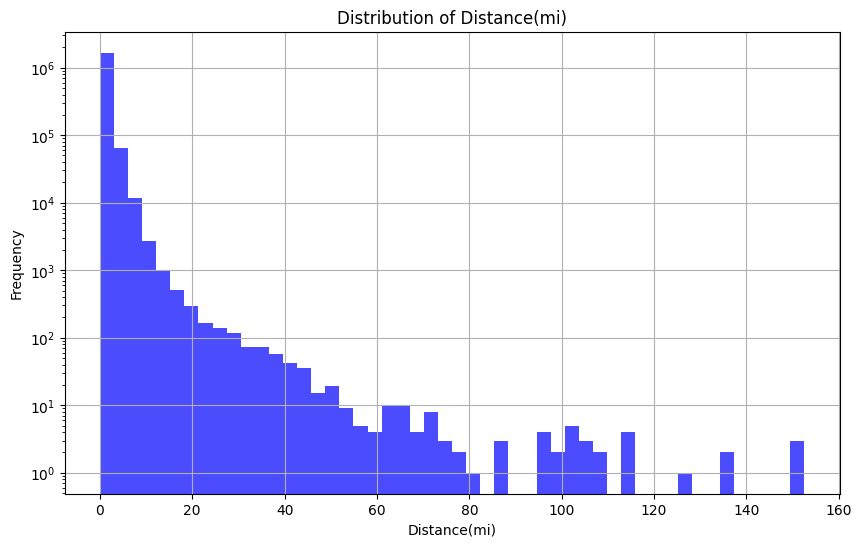

In [ ]:
distance = df.select("Distance(mi)").dropna().rdd.flatMap(lambda x: x).collect()

# Now plot the data using matplotlib
plt.figure(figsize=(10,6))
plt.hist(distance, bins=50, color='blue', alpha=0.7)
plt.yscale('log', nonpositive='clip') # This line sets the y-axis to a logarithmic scale
plt.title('Distribution of Distance(mi)')
plt.xlabel('Distance(mi)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

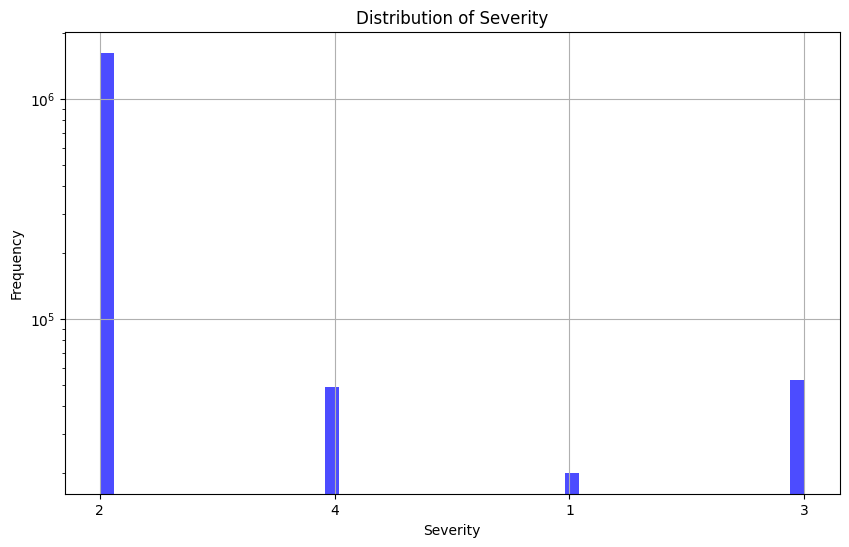

In [ ]:
seve = df.select("Severity").dropna().rdd.flatMap(lambda x: x).collect()

# Now plot the data using matplotlib
plt.figure(figsize=(10,6))
plt.hist(seve, bins=50, color='blue', alpha=0.7)
plt.yscale('log', nonpositive='clip') # This line sets the y-axis to a logarithmic scale
plt.title('Distribution of Severity')
plt.xlabel('Severity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

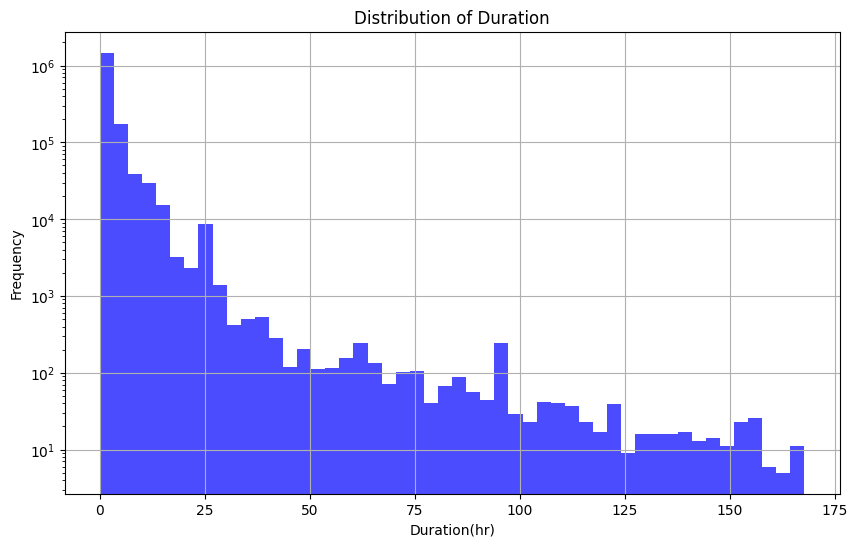

In [ ]:
duration = df.select("Duration").dropna().rdd.flatMap(lambda x: x).collect()

# Now plot the data using matplotlib
plt.figure(figsize=(10,6))
plt.hist(duration, bins=50, color='blue', alpha=0.7)
plt.yscale('log', nonpositive='clip') # This line sets the y-axis to a logarithmic scale
plt.title('Distribution of Duration')
plt.xlabel('Duration(hr)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

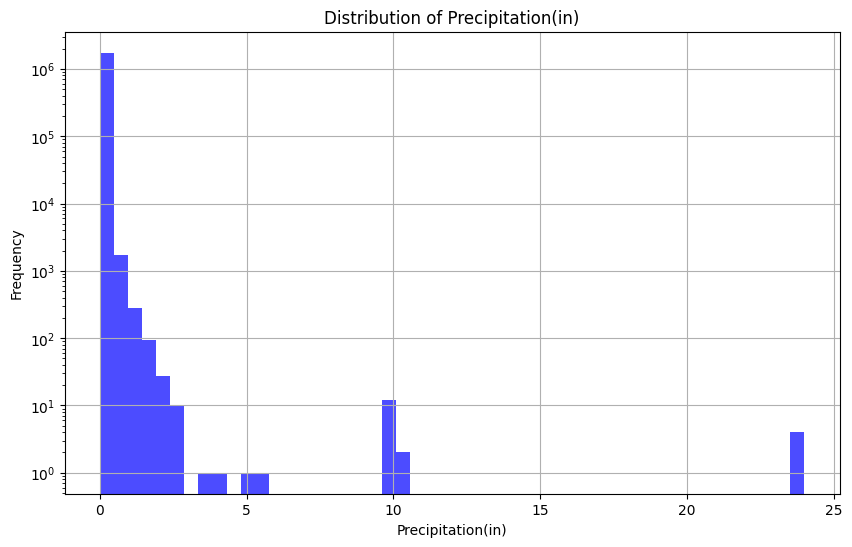

In [ ]:
# First, convert the precipitation data to a list in your local environment
precipitation_data = df.select('Precipitation(in)').dropna().rdd.flatMap(lambda x: x).collect()

# Now plot the data using matplotlib
plt.figure(figsize=(10,6))
plt.hist(precipitation_data, bins=50, color='blue', alpha=0.7)
plt.yscale('log', nonpositive='clip') # This line sets the y-axis to a logarithmic scale
plt.title('Distribution of Precipitation(in)')
plt.xlabel('Precipitation(in)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Calculate summary stats
rain_median = df.stat.approxQuantile('Precipitation(in)', [0.5], 0)[0]
rain_mean = df.agg(F.avg('Precipitation(in)')).first()[0]
rain_sd = df.agg(stddev("Precipitation(in)")).collect()[0][0]
print("Precipitation median = ", rain_median)
print("Precipitation mean = ", round(rain_mean, 3))
print("Precipitation standard dev = ", round(rain_sd, 3))

Precipitation median =  0.0
Precipitation mean =  0.005
Precipitation standard dev =  0.061


In [ ]:
# Create treatment variables
df = df.withColumn('Rained', when(df['Precipitation(in)'] >= 0.1, 1).otherwise(0))

# Check balance
print("Treatment & Control Group Balance:")
print(df.groupBy("Rained").count().show())

Treatment & Control Group Balance:


+------+-------+
|Rained|  count|
+------+-------+
|     1|  26499|
|     0|1719037|
+------+-------+

None


In [ ]:
df.show(10)

+-------+--------+--------------------+--------------------+--------------------+----+------------+--------------+-----+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+----------+----------+-----------+-------------+------------------+--------+------------------------+-------------------+----------------------+-----------------+------+
|     ID|Severity|          Start_Time|            End_Time|        Distance(mi)|Side|        City|        County|State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Population|Start_Year|Start_Month|Start_Weekday|Start_TOD_Category|Duration|Start_TOD_Category_index|Start_Weekday_index|Start_TOD_Categ

#### Precipitation

### Severity

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Severity", "Rained"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Rained") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Rained") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Rained', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Severity', 'Rained', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Rained', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Rained'] == 1]
    df_control = ps_pd[ps_pd['Rained'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['Severity_treatment'] = matched_pairs['Severity_treatment'].astype(float)
    matched_pairs['Severity_control'] = matched_pairs['Severity_control'].astype(float)

    matched_pairs['treatment_effect'] = matched_pairs['Severity_treatment'] - matched_pairs['Severity_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


AUC = 0.641


ATE = 0.02


Fraction =  0.1


AUC = 0.639


ATE = 0.035


Fraction =  0.2


AUC = 0.641


ATE = 0.0148


Fraction =  0.3


AUC = 0.64


ATE = 0.0104


Fraction =  0.4


AUC = 0.641


ATE = 0.0157


Fraction =  0.5


AUC = 0.642


ATE = 0.0104


Fraction =  0.6


AUC = 0.642


ATE = 0.0151


Fraction =  0.7


AUC = 0.642


ATE = 0.016


Fraction =  0.8


AUC = 0.642


ATE = 0.0112


#### Summary

The average treatment effect of precipitation on accident severity (measured on a scale of 1 to 4, with 4 being the most severe) is 0.035 unit. 

### Duration

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Duration", "Rained"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Rained") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Rained") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Rained', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Duration', 'Rained', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Rained', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Rained'] == 1]
    df_control = ps_pd[ps_pd['Rained'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['treatment_effect'] = matched_pairs['Duration_treatment'] - matched_pairs['Duration_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


AUC = 0.642


ATE = -0.4879


Fraction =  0.1


AUC = 0.643


ATE = -0.3666


Fraction =  0.2


AUC = 0.642


ATE = -0.4463


Fraction =  0.3


AUC = 0.643


ATE = -0.4459


Fraction =  0.4


AUC = 0.641


ATE = -0.4827


Fraction =  0.5


AUC = 0.64


ATE = -0.389


Fraction =  0.6


AUC = 0.643


ATE = -0.3706


Fraction =  0.7


AUC = 0.642


ATE = -0.3737


Fraction =  0.8


AUC = 0.642


ATE = -0.452


#### Summary

The average treatment effect of precipitation on accident duration (measured in hours) is -0.49 hour. 

### Distance

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Distance(mi)", "Rained"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Rained") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Rained") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Rained', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Distance(mi)', 'Rained', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Rained', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Rained'] == 1]
    df_control = ps_pd[ps_pd['Rained'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['treatment_effect'] = matched_pairs['Distance(mi)_treatment'] - matched_pairs['Distance(mi)_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


AUC = 0.645


ATE = 0.1948


Fraction =  0.1


AUC = 0.645


ATE = 0.0214


Fraction =  0.2


AUC = 0.644


ATE = 0.1278


Fraction =  0.3


AUC = 0.645


ATE = 0.1384


Fraction =  0.4


AUC = 0.646


ATE = 0.1333


Fraction =  0.5


AUC = 0.645


ATE = 0.1145


Fraction =  0.6


AUC = 0.646


ATE = 0.0895


Fraction =  0.7


AUC = 0.645


ATE = 0.0547


Fraction =  0.8


AUC = 0.645


ATE = 0.1131


#### Summary

The average treatment effect of precipitation on accident distance impacted (measured in miles) is 0.2 miles. 

#### Population

### Severity

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
cutoff = [pop_median, pop_mean, pop_65, pop_75, pop_85, pop_95]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Precipitation(in)', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Severity", "City Size"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in cutoff:
    print("\n")
    print("Cut-off =", i)
    # Create treatment variables
    df = df.withColumn('City Size', when(df['Population'] >= i, 1).otherwise(0))

    # Check balance
    print("Treatment & Control Group Balance:")
    print(df.groupBy("City Size").count().show())

    df_ps = df.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='City Size', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Severity', 'City Size', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='City Size', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['City Size'] == 1]
    df_control = ps_pd[ps_pd['City Size'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))

    matched_pairs['Severity_treatment'] = matched_pairs['Severity_treatment'].astype(float)
    matched_pairs['Severity_control'] = matched_pairs['Severity_control'].astype(float)

    matched_pairs['treatment_effect'] = matched_pairs['Severity_treatment'] - matched_pairs['Severity_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))

#### Summary

The average treatment effect of population size on accident severity (measured on a scale of 1 to 4, with 4 being the most severe) is 0.0146 unit. 

median: AUC = 0.632, ATE = -0.0473

65th: AUC = 0.63, ATE = -0.0308

75th: AUC = , ATE = -0.0227

mean: AUC = 0.636, ATE = -0.0054

85th: AUC = 0.649, ATE = 0.0121 

95th: AUC = 0.666, ATE = 0.0146

### Duration

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
cutoff = [pop_median, pop_mean, pop_65, pop_75, pop_85, pop_95]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Precipitation(in)', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Duration", "City Size"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in cutoff:
    print("\n")
    print("Cut-off =", i)
    # Create treatment variables
    df = df.withColumn('City Size', when(df['Population'] >= i, 1).otherwise(0))

    # Check balance
    print("Treatment & Control Group Balance:")
    print(df.groupBy("City Size").count().show())

    df_ps = df.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='City Size', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Duration', 'City Size', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='City Size', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['City Size'] == 1]
    df_control = ps_pd[ps_pd['City Size'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))

    matched_pairs['treatment_effect'] = matched_pairs['Duration_treatment'] - matched_pairs['Duration_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Cut-off = 105087.0
Treatment & Control Group Balance:


+---------+------+
|City Size| count|
+---------+------+
|        1|872815|
|        0|872721|
+---------+------+

None


AUC = 0.633


ATE = -0.0195


Cut-off = 1176674.0367743776
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 393126|
|        0|1352410|
+---------+-------+

None


AUC = 0.635


ATE = 0.0692


Cut-off = 399929.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 611034|
|        0|1134502|
+---------+-------+

None


AUC = 0.631


ATE = 0.0156


Cut-off = 1062018.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 437042|
|        0|1308494|
+---------+-------+

None


AUC = 0.627


ATE = 0.0556


Cut-off = 1927699.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 286287|
|        0|1459249|
+---------+-------+

None


AUC = 0.649


ATE = 0.1988


Cut-off = 5668165.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 110293|
|        0|1635243|
+---------+-------+

None


AUC = 0.67


ATE = 0.4093


#### Summary

The average treatment effect of population size on accident duration (measured in hours) is 0.41 hour. 

### Distance

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
cutoff = [pop_median, pop_mean, pop_65, pop_75, pop_85, pop_95]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Precipitation(in)', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Distance(mi)", "City Size"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in cutoff:
    print("\n")
    print("Cut-off =", i)
    # Create treatment variables
    df = df.withColumn('City Size', when(df['Population'] >= i, 1).otherwise(0))

    # Check balance
    print("Treatment & Control Group Balance:")
    print(df.groupBy("City Size").count().show())

    df_ps = df.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='City Size', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Distance(mi)', 'City Size', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='City Size', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['City Size'] == 1]
    df_control = ps_pd[ps_pd['City Size'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))

    matched_pairs['treatment_effect'] = matched_pairs['Distance(mi)_treatment'] - matched_pairs['Distance(mi)_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Cut-off = 105087.0
Treatment & Control Group Balance:


+---------+------+
|City Size| count|
+---------+------+
|        1|872815|
|        0|872721|
+---------+------+

None


23/06/08 16:13:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/08 16:13:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


AUC = 0.632


ATE = -0.1852


Cut-off = 1176674.0367743776
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 393126|
|        0|1352410|
+---------+-------+

None


AUC = 0.636


ATE = -0.2034


Cut-off = 399929.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 611034|
|        0|1134502|
+---------+-------+

None


AUC = 0.63


ATE = -0.2375


Cut-off = 1062018.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 437042|
|        0|1308494|
+---------+-------+

None


AUC = 0.628


ATE = -0.224


Cut-off = 1927699.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 286287|
|        0|1459249|
+---------+-------+

None


AUC = 0.649


ATE = -0.1789


Cut-off = 5668165.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 110293|
|        0|1635243|
+---------+-------+

None


AUC = 0.667


ATE = -0.1284


#### Summary

The average treatment effect of population size on accident distance impacted is -0.24 miles.

More pop, more emergency response personnel.
Or more likely to occure in city streets, where distances are shorter and have more alternative routes to disperse traffic.

#### Stop Sign

### Severity

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Precipitation(in)', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Severity", "Stop"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Stop") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Stop") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Stop', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Severity', 'Stop', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Stop', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Stop'] == 1]
    df_control = ps_pd[ps_pd['Stop'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['Severity_treatment'] = matched_pairs['Severity_treatment'].astype(float)
    matched_pairs['Severity_control'] = matched_pairs['Severity_control'].astype(float)

    matched_pairs['treatment_effect'] = matched_pairs['Severity_treatment'] - matched_pairs['Severity_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


23/06/08 16:25:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/08 16:25:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


AUC = 0.724


ATE = -0.0033


Fraction =  0.1


AUC = 0.721


ATE = 0.0038


Fraction =  0.2


AUC = 0.723


ATE = -0.0252


Fraction =  0.3


AUC = 0.722


ATE = -0.0007


Fraction =  0.4


AUC = 0.722


ATE = 0.0128


Fraction =  0.5


AUC = 0.722


ATE = -0.0015


Fraction =  0.6


AUC = 0.723


ATE = -0.0058


Fraction =  0.7


AUC = 0.723


ATE = -0.0073


Fraction =  0.8


AUC = 0.723


ATE = 0.0064


#### Summary

The average treatment effect of having a stop sign nearby on accident severity (measured on a scale of 1 to 4, with 4 being the most severe) is -0.003 unit. 

### Duration

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Precipitation(in)', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Duration", "Stop"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Stop") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Stop") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Stop', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Duration', 'Stop', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Stop', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Stop'] == 1]
    df_control = ps_pd[ps_pd['Stop'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['treatment_effect'] = matched_pairs['Duration_treatment'] - matched_pairs['Duration_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


AUC = 0.723


ATE = 0.5207


Fraction =  0.1


AUC = 0.72


ATE = 0.4219


Fraction =  0.2


AUC = 0.721


ATE = 0.3575


Fraction =  0.3


AUC = 0.721


ATE = 0.388


Fraction =  0.4


AUC = 0.723


ATE = 0.5165


Fraction =  0.5


AUC = 0.723


ATE = 0.4512


Fraction =  0.6


AUC = 0.723


ATE = 0.4366


Fraction =  0.7


AUC = 0.722


ATE = 0.441


Fraction =  0.8


AUC = 0.723


ATE = 0.4415


#### Summary

The average treatment effect of having a stop sign nearby on accident duration (measured in hours) is 0.51 hour. 

### Distance

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Precipitation(in)', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Distance(mi)", "Stop"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Stop") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Stop") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Stop', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Distance(mi)', 'Stop', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Stop', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Stop'] == 1]
    df_control = ps_pd[ps_pd['Stop'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['treatment_effect'] = matched_pairs['Distance(mi)_treatment'] - matched_pairs['Distance(mi)_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


AUC = 0.722


ATE = -0.402


Fraction =  0.1


AUC = 0.72


ATE = -0.3131


Fraction =  0.2


AUC = 0.722


ATE = -0.2628


Fraction =  0.3


AUC = 0.723


ATE = -0.4389


Fraction =  0.4


AUC = 0.723


ATE = -0.42


Fraction =  0.5


AUC = 0.723


ATE = -0.3973


Fraction =  0.6


AUC = 0.723


ATE = -0.3984


Fraction =  0.7


AUC = 0.722


ATE = -0.408


Fraction =  0.8


AUC = 0.723


ATE = -0.3985


#### Summary

The average treatment effect of having a stop sign nearby on accident distance impacted (measured in miles) is -0.44 miles. 

#### Traffic Signal

### Severity

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Humidity(%)', 'Temperature(F)', 
              'Visibility(mi)', 'Amenity', 'Bump', 'Stop', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 
              'Roundabout', 'Station', 'Precipitation(in)', 'Traffic_Calming', 'Crossing', 'Turning_Loop', 
              'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Severity", "Traffic_Signal"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Traffic_Signal") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Traffic_Signal") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Traffic_Signal', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Severity', 'Traffic_Signal', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Traffic_Signal', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Traffic_Signal'] == 1]
    df_control = ps_pd[ps_pd['Traffic_Signal'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['Severity_treatment'] = matched_pairs['Severity_treatment'].astype(float)
    matched_pairs['Severity_control'] = matched_pairs['Severity_control'].astype(float)
    
    matched_pairs['treatment_effect'] = matched_pairs['Severity_treatment'] - matched_pairs['Severity_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.2


AUC = 0.78


ATE = -0.0279


Fraction =  0.3


AUC = 0.781


ATE = -0.0103


Fraction =  0.4


AUC = 0.78


ATE = -0.0172


Fraction =  0.5


AUC = 0.78


ATE = 0.0017


Fraction =  0.6


AUC = 0.779


ATE = 0.0112


Fraction =  0.7


AUC = 0.779


ATE = -0.0067


Fraction =  0.8


AUC = 0.779


ATE = -0.0023


#### Summary

The average treatment effect of having a traffic signal nearby on accident severity (measured on a scale of 1 to 4, with 4 being the most severe) is -0.03 unit. 

### Duration

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Humidity(%)', 'Temperature(F)', 
              'Visibility(mi)', 'Amenity', 'Bump', 'Stop', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 
              'Roundabout', 'Station', 'Precipitation(in)', 'Traffic_Calming', 'Crossing', 'Turning_Loop', 
              'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Duration", "Traffic_Signal"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Traffic_Signal") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Traffic_Signal") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Traffic_Signal', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Duration', 'Traffic_Signal', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Traffic_Signal', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Traffic_Signal'] == 1]
    df_control = ps_pd[ps_pd['Traffic_Signal'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['treatment_effect'] = matched_pairs['Duration_treatment'] - matched_pairs['Duration_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


AUC = 0.782


ATE = nan


Fraction =  0.1


AUC = 0.782


ATE = nan


Fraction =  0.2


AUC = 0.781


ATE = -0.5492


Fraction =  0.3


AUC = 0.782


ATE = -0.6268


Fraction =  0.4


AUC = 0.781


ATE = -0.2893


Fraction =  0.5


AUC = 0.781


ATE = -0.3558


Fraction =  0.6


AUC = 0.781


ATE = -0.2423


Fraction =  0.7


AUC = 0.78


ATE = -0.3413


Fraction =  0.8


AUC = 0.78


ATE = -0.4505


#### Summary

The average treatment effect of having a traffic signal nearby on accident duration (measured in hours) is -0.62 hour. 

### Distance

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Humidity(%)', 'Temperature(F)', 
              'Visibility(mi)', 'Amenity', 'Bump', 'Stop', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 
              'Roundabout', 'Station', 'Precipitation(in)', 'Traffic_Calming', 'Crossing', 'Turning_Loop', 
              'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Distance(mi)", "Traffic_Signal"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Traffic_Signal") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Traffic_Signal") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Traffic_Signal', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Distance(mi)', 'Traffic_Signal', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Traffic_Signal', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Traffic_Signal'] == 1]
    df_control = ps_pd[ps_pd['Traffic_Signal'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['treatment_effect'] = matched_pairs['Distance(mi)_treatment'] - matched_pairs['Distance(mi)_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.2


AUC = 0.781


ATE = -0.3921


Fraction =  0.3


AUC = 0.78


ATE = -0.4592


Fraction =  0.4


AUC = 0.779


ATE = -0.4461


Fraction =  0.5


AUC = 0.778


ATE = -0.5383


Fraction =  0.6


AUC = 0.778


ATE = -0.5632


Fraction =  0.7


AUC = 0.779


ATE = -0.523


Fraction =  0.8


AUC = 0.778


ATE = -0.4762


#### Summary

The average treatment effect of having a traffic crossing nearby on accident distance impacted (measured in miles) is -0.56 miles. 

#### Junction

### Severity

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Humidity(%)', 'Temperature(F)', 
              'Visibility(mi)', 'Amenity', 'Bump', 'Stop', 'Give_Way', 'Traffic_Signal', 'No_Exit', 'Railway', 
              'Roundabout', 'Station', 'Precipitation(in)', 'Traffic_Calming', 'Crossing', 'Turning_Loop', 
              'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Severity", "Junction"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Junction") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Junction") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Junction', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Severity', 'Junction', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Junction', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Junction'] == 1]
    df_control = ps_pd[ps_pd['Junction'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['Severity_treatment'] = matched_pairs['Severity_treatment'].astype(float)
    matched_pairs['Severity_control'] = matched_pairs['Severity_control'].astype(float)

    matched_pairs['treatment_effect'] = matched_pairs['Severity_treatment'] - matched_pairs['Severity_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.15


23/06/08 18:26:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/08 18:26:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


AUC = 0.683


ATE = 0.0828


Fraction =  0.2


AUC = 0.685


ATE = 0.0372


Fraction =  0.3


AUC = 0.683


ATE = 0.0541


Fraction =  0.4


AUC = 0.683


ATE = 0.0715


Fraction =  0.5


AUC = 0.684


ATE = 0.0551


Fraction =  0.6


AUC = 0.682


ATE = 0.0878


Fraction =  0.7


AUC = 0.683


ATE = 0.0577


Fraction =  0.8


AUC = 0.684


ATE = 0.0815


#### Summary

The average treatment effect of having a junction nearby on accident severity (measured on a scale of 1 to 4, with 4 being the most severe) is -0.09 unit. 

### Duration

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Humidity(%)', 'Temperature(F)', 
              'Visibility(mi)', 'Amenity', 'Bump', 'Stop', 'Give_Way', 'Traffic_Signal', 'No_Exit', 'Railway', 
              'Roundabout', 'Station', 'Precipitation(in)', 'Traffic_Calming', 'Crossing', 'Turning_Loop', 
              'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Duration", "Junction"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Junction") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Junction") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Junction', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Duration', 'Junction', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Junction', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Junction'] == 1]
    df_control = ps_pd[ps_pd['Junction'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
  
    matched_pairs['treatment_effect'] = matched_pairs['Duration_treatment'] - matched_pairs['Duration_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.15


AUC = 0.682


ATE = -0.4895


Fraction =  0.2


AUC = 0.686


ATE = -0.4311


Fraction =  0.3


AUC = 0.684


ATE = -0.4012


Fraction =  0.4


AUC = 0.684


ATE = -0.4854


Fraction =  0.5


AUC = 0.684


ATE = -0.4387


Fraction =  0.6


AUC = 0.684


ATE = -0.4468


Fraction =  0.7


AUC = 0.686


ATE = -0.584


Fraction =  0.8


AUC = 0.684


ATE = -0.4411


#### Summary

The average treatment effect of having a traffic crossing nearby on accident duration (measured in hours) is -0.58 hour. 

### Distance

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Humidity(%)', 'Temperature(F)', 
              'Visibility(mi)', 'Amenity', 'Bump', 'Stop', 'Give_Way', 'Traffic_Signal', 'No_Exit', 'Railway', 
              'Roundabout', 'Station', 'Precipitation(in)', 'Traffic_Calming', 'Crossing', 'Turning_Loop', 
              'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Distance(mi)", "Junction"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Junction") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Junction") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Junction', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Distance(mi)', 'Junction', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Junction', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Junction'] == 1]
    df_control = ps_pd[ps_pd['Junction'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
  
    matched_pairs['treatment_effect'] = matched_pairs['Distance(mi)_treatment'] - matched_pairs['Distance(mi)_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.15


AUC = 0.683


ATE = 0.1808


Fraction =  0.2


AUC = 0.683


ATE = 0.2668


Fraction =  0.3


AUC = 0.683


ATE = 0.322


Fraction =  0.4


AUC = 0.684


ATE = 0.1443


Fraction =  0.5


AUC = 0.683


ATE = 0.306


Fraction =  0.6


AUC = 0.683


ATE = 0.192


Fraction =  0.7


AUC = 0.685


ATE = 0.1028


Fraction =  0.8


AUC = 0.685


ATE = 0.0551


#### Summary

The average treatment effect of having a junction nearby on accident distance impacted (measured in miles) is 0.33 miles. 

#### Crossing

### Severity

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Stop', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Precipitation(in)', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Severity", "Crossing"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Crossing") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Crossing") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Crossing', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Severity', 'Crossing', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Crossing', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Crossing'] == 1]
    df_control = ps_pd[ps_pd['Crossing'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['Severity_treatment'] = matched_pairs['Severity_treatment'].astype(float)
    matched_pairs['Severity_control'] = matched_pairs['Severity_control'].astype(float)

    matched_pairs['treatment_effect'] = matched_pairs['Severity_treatment'] - matched_pairs['Severity_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


23/06/08 17:02:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/08 17:02:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


AUC = 0.866


ATE = nan


Fraction =  0.1


AUC = 0.865


ATE = -0.0043


Fraction =  0.2


AUC = 0.865


ATE = -0.087


Fraction =  0.3


AUC = 0.865


ATE = -0.0344


Fraction =  0.4


AUC = 0.865


ATE = -0.0212


Fraction =  0.5


AUC = 0.866


ATE = -0.0461


Fraction =  0.6


AUC = 0.865


ATE = -0.0301


Fraction =  0.7


AUC = 0.865


ATE = -0.0632


Fraction =  0.8


AUC = 0.865


ATE = -0.04


#### Summary

The average treatment effect of having a traffic crossing nearby on accident severity (measured on a scale of 1 to 4, with 4 being the most severe) is -0.09 unit. 

### Duration

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Stop', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Precipitation(in)', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Duration", "Crossing"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Crossing") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Crossing") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Crossing', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Duration', 'Crossing', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Crossing', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Crossing'] == 1]
    df_control = ps_pd[ps_pd['Crossing'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['treatment_effect'] = matched_pairs['Duration_treatment'] - matched_pairs['Duration_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


AUC = 0.868


ATE = nan


Fraction =  0.1


AUC = 0.866


ATE = 0.1051


Fraction =  0.2


AUC = 0.868


ATE = 0.2729


Fraction =  0.3


AUC = 0.868


ATE = -0.1154


Fraction =  0.4


AUC = 0.868


ATE = 0.1551


Fraction =  0.5


AUC = 0.867


ATE = 0.1403


Fraction =  0.6


AUC = 0.867


ATE = 0.0568


Fraction =  0.7


AUC = 0.867


ATE = 0.3336


Fraction =  0.8


AUC = 0.867


ATE = 0.2267


#### Summary

The average treatment effect of having a traffic crossing nearby on accident duration (measured in hours) is 0.33 hour. 

### Distance

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Stop', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Precipitation(in)', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Distance(mi)", "Crossing"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Crossing") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Crossing") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Crossing', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Distance(mi)', 'Crossing', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Crossing', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Crossing'] == 1]
    df_control = ps_pd[ps_pd['Crossing'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['treatment_effect'] = matched_pairs['Distance(mi)_treatment'] - matched_pairs['Distance(mi)_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


AUC = 0.871


ATE = nan


Fraction =  0.1


AUC = 0.87


ATE = -0.2506


Fraction =  0.2


AUC = 0.87


ATE = -0.405


Fraction =  0.3


AUC = 0.87


ATE = -0.4433


Fraction =  0.4


AUC = 0.871


ATE = -0.5874


Fraction =  0.5


AUC = 0.871


ATE = -0.6532


Fraction =  0.6


AUC = 0.87


ATE = -0.4694


Fraction =  0.7


AUC = 0.87


ATE = -0.2901


Fraction =  0.8


AUC = 0.87


ATE = -0.3505


#### Summary

The average treatment effect of having a traffic crossing nearby on accident distance impacted (measured in miles) is -0.65 miles. 

#### Station

### Severity

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Humidity(%)', 'Temperature(F)', 
              'Visibility(mi)', 'Amenity', 'Bump', 'Stop', 'Give_Way', 'Traffic_Signal', 'No_Exit', 'Railway', 
              'Roundabout', 'Junction', 'Precipitation(in)', 'Traffic_Calming', 'Crossing', 'Turning_Loop', 
              'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Severity", "Station"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Station") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Station") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Station', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Severity', 'Station', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Station', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Station'] == 1]
    df_control = ps_pd[ps_pd['Station'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['Severity_treatment'] = matched_pairs['Severity_treatment'].astype(float)
    matched_pairs['Severity_control'] = matched_pairs['Severity_control'].astype(float)

    matched_pairs['treatment_effect'] = matched_pairs['Severity_treatment'] - matched_pairs['Severity_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


23/06/08 19:13:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/08 19:13:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


AUC = 0.817


ATE = -0.0147


Fraction =  0.1


AUC = 0.816


ATE = -0.0225


Fraction =  0.2


AUC = 0.815


ATE = -0.083


Fraction =  0.3


AUC = 0.814


ATE = -0.0168


Fraction =  0.4


AUC = 0.813


ATE = 0.0185


Fraction =  0.5


AUC = 0.813


ATE = -0.0043


Fraction =  0.6


AUC = 0.813


ATE = -0.0269


Fraction =  0.7


AUC = 0.813


ATE = -0.0029


Fraction =  0.8


AUC = 0.813


ATE = -0.0012


#### Summary

The average treatment effect of having a station nearby on accident severity (measured on a scale of 1 to 4, with 4 being the most severe) is -0.0269 unit. 

### Duration

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Humidity(%)', 'Temperature(F)', 
              'Visibility(mi)', 'Amenity', 'Bump', 'Stop', 'Give_Way', 'Traffic_Signal', 'No_Exit', 'Railway', 
              'Roundabout', 'Junction', 'Precipitation(in)', 'Traffic_Calming', 'Crossing', 'Turning_Loop', 
              'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Duration", "Station"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Station") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Station") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Station', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Duration', 'Station', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Station', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Station'] == 1]
    df_control = ps_pd[ps_pd['Station'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
  
    matched_pairs['treatment_effect'] = matched_pairs['Duration_treatment'] - matched_pairs['Duration_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


AUC = 0.813


ATE = 0.7668


Fraction =  0.1


AUC = 0.815


ATE = 0.758


Fraction =  0.2


AUC = 0.814


ATE = 0.723


Fraction =  0.3


AUC = 0.814


ATE = 0.6128


Fraction =  0.4


AUC = 0.813


ATE = 0.6513


Fraction =  0.5


AUC = 0.812


ATE = 0.5636


Fraction =  0.6


AUC = 0.812


ATE = 0.5671


Fraction =  0.7


AUC = 0.813


ATE = 0.694


Fraction =  0.8


AUC = 0.813


ATE = 0.5443


#### Summary

The average treatment effect of having a station nearby on accident duration (measured in hours) is 0.76 hour. 

### Distance

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [ ]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Humidity(%)', 'Temperature(F)', 
              'Visibility(mi)', 'Amenity', 'Bump', 'Stop', 'Give_Way', 'Traffic_Signal', 'No_Exit', 'Railway', 
              'Roundabout', 'Junction', 'Precipitation(in)', 'Traffic_Calming', 'Crossing', 'Turning_Loop', 
              'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Distance(mi)", "Station"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Station") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Station") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Station', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Distance(mi)', 'Station', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Station', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Station'] == 1]
    df_control = ps_pd[ps_pd['Station'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
  
    matched_pairs['treatment_effect'] = matched_pairs['Distance(mi)_treatment'] - matched_pairs['Distance(mi)_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


AUC = 0.813


ATE = -0.3746


Fraction =  0.1


AUC = 0.814


ATE = -0.3931


Fraction =  0.2


AUC = 0.814


ATE = -0.3299


Fraction =  0.3


AUC = 0.812


ATE = -0.5803


Fraction =  0.4


AUC = 0.812


ATE = -0.6213


Fraction =  0.5


AUC = 0.811


ATE = -0.5981


Fraction =  0.6


AUC = 0.811


ATE = -0.5901


Fraction =  0.7


AUC = 0.812


ATE = -0.5537


Fraction =  0.8


AUC = 0.812


ATE = -0.5402


#### Summary

The average treatment effect of having a station nearby on accident distance impacted (measured in miles) is -0.62 miles. 